# CS4035 Cyber Data Analytics
## Group 15

Student ID 5011639

Student ID 4998707


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data = "./data/data_for_student_case.csv"
df = pd.read_csv(data)

# I. Data Pre-Processing

We prepare the data for visualization and modelling.

Functions used for data pre-processing can be found in [Part1/preprocessing.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/preprocessing.py)

In [5]:
from preprocessing import *

## A. Re-Label

Column `simple_journal` has the payment status.

`relabel()`:
- drops rows which have `simple_journal` = "Refused", since we are not sure whether it was fraud.
- replaces `simple_journal` = "Chargeback" with `1`, i.e. fraud.
- replaces `simple_journal` = "Settled" with `0`, i.e. not fraud.

In [6]:
df = relabel(df)

non_fraud_count = df[df["simple_journal"] == 0].shape[0]
fraud_count = df[df["simple_journal"] == 1].shape[0]
print(f"Class Distribution: label 1 = {fraud_count/df.shape[0]}, label 0 = {non_fraud_count/df.shape[0]}")

/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Class Distribution: label 1 = 0.00145547511770364, label 0 = 0.9985445248822964


## B. Check for NaNs

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   txid                          237036 non-null  int64  
 1   bookingdate                   237036 non-null  object 
 2   issuercountrycode             237032 non-null  object 
 3   txvariantcode                 237036 non-null  object 
 4   bin                           237036 non-null  float64
 5   amount                        237036 non-null  float64
 6   currencycode                  237036 non-null  object 
 7   shoppercountrycode            236694 non-null  object 
 8   shopperinteraction            237036 non-null  object 
 9   simple_journal                237036 non-null  int32  
 10  cardverificationcodesupplied  223842 non-null  object 
 11  cvcresponsecode               237036 non-null  int64  
 12  creationdate                  237036 non-nul

**Remove NaNs from `issuercountrycode`, `shoppercountrycode` and `cardverificationcodesupplied`**

We replace NaN with `False` for `cardverificationcodesupplied` since we assume missing value means card verification code was not supplied.

Rest are replaced with dummy values which we numerically encode below

In [8]:
df = replace_na_with(df, "cardverificationcodesupplied", False)
df = replace_na_with(df, "issuercountrycode", "ZZ")
df = replace_na_with(df, "shoppercountrycode", "ZZ")

**Remove NaN in `mail_id`**

The NaNs in `mail_id` column are strings "na", which we replace with dummy value "email99999" and later encode it numerically

In [9]:
df.loc[df["mail_id"].str.contains("na", case=False), "mail_id"] = "email99999"

## C. Convert `creationdate` and `bookingdate` to a pandas datetime object

This allows more flexibility later for date wise aggregation using datetime functions

In [10]:
df["creationdate"] = pd.to_datetime(df["creationdate"])
df["date"] = df["creationdate"].dt.date

df["bookingdate"] = pd.to_datetime(df["bookingdate"])

## D. Encode `issuecountrycode` and `shoppercountrycode`

- First we create a country code list that encapsulates both shopper and issue country codes
- Then we encode `issuecountrycode` and `shoppercountrycode` using this full list

In [11]:
unique_issuer_cc = df["issuercountrycode"].unique().tolist()
unique_shopper_cc = df["shoppercountrycode"].unique().tolist()
unique_codes = list(set(unique_issuer_cc + unique_shopper_cc))
df, issuer_country_enc = encode(df, "issuercountrycode", values=unique_codes)
df, shopper_country_enc = encode(df, "shoppercountrycode", values=unique_codes)

## E. Convert transaction amount in `amount` to EUR

- The transaction amount in the `amount` column is in the currency according to the `currencycode` column
- We convert all transaction amounts to euros using a fixed exchange rate

In [12]:
df["amount_eur"] = df.apply(lambda x: conv_to_eur(x), axis=1)

## F. Replace `accountcode` with the respective Country Code

In [13]:
df["accountcode"] = df["accountcode"].apply(lambda x: re.sub("Account", "", x))
df["accountcode_cc"] = 0
df.loc[(df["accountcode"] == "UK"), "accountcode_cc"] = "GB"
df.loc[(df["accountcode"] == "Mexico"), "accountcode_cc"] = "MX"
df.loc[(df["accountcode"] == "Sweden"), "accountcode_cc"] = "SE"
df.loc[(df["accountcode"] == "APAC"), "accountcode_cc"] = "APAC"
df.drop(["accountcode"], axis=1, inplace=True)

## G. Replace all `cvcresponsecode` values above 2 with a single value

`cvcresponsecode` 3 - 6 correspond to "not checked" and can be merged into one

In [14]:
df.loc[df["cvcresponsecode"] > 2, "cvcresponsecode"] = 3

## H. Numerical Encoding of categorical columns

We can replace the categorical columns with positive integers, since we need numbers to input to the ML Model

In [15]:
df, card_enc = encode(df, "card_id")
df, ip_enc = encode(df, "ip_id")
df, tx_var_enc = encode(df, "txvariantcode")
df, shop_enc = encode(df, "shopperinteraction")
df, card_verif_enc = encode(df, "cardverificationcodesupplied")
df, email_enc = encode(df, "mail_id")
df, currency_enc = encode(df, "currencycode")
df, account_cc_enc = encode(df, "accountcode_cc")

## I. Distribution of the Transaction Amount

- We analyse the distribution of `amount_eur` column for fraud and non-fraud cases
- We hope to find a significant difference between them which will allow us to classify the cases well
- To do this, we make a boxplot to see the quartiles and outliers

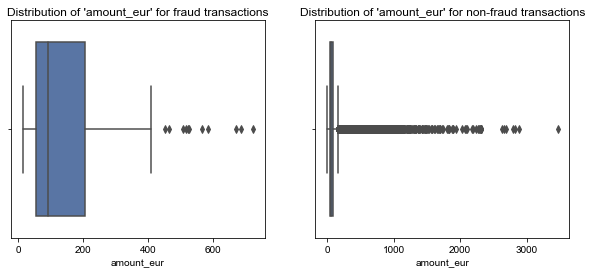

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.set(style="whitegrid")
sns.boxplot(x="amount_eur", data=df[df.simple_journal == 1], ax=ax1)
ax1.set_title("Distribution of 'amount_eur' for fraud transactions")

sns.boxplot(x="amount_eur", data=df[df.simple_journal == 0], ax=ax2)
ax2.set_title("Distribution of 'amount_eur' for non-fraud transactions")
plt.show()

We can see here that there are outlier values for the non-fraud case. For further analysis, we remove the records where an amount > 180 is spent in a non-fraudulent transaction.

In [17]:
df = df[(df["amount_eur"] <= 150)|(df["simple_journal"] == 1)]

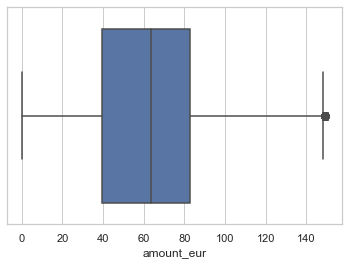

In [18]:
sns.set(style="whitegrid")
sns.boxplot(x="amount_eur", data=df[df.simple_journal == 0])

Now, if we compare this to the distribution of transaction amount in the fraudulent cases, there is a significant difference in distribution

---
---

# II. Visualization Task


## A. Heatmap with absolute difference in correlation

We usually visualize the correlation of the features with each other to see if there exist any meaningful relationships that differ in cases of fraud vs. no fraud

But it is really hard to see which parts are different for fraud vs. normal, so we create another heatmap with a difference in correlation so the important correlations are highlighted

In [19]:
from sklearn.manifold import TSNE, Isomap

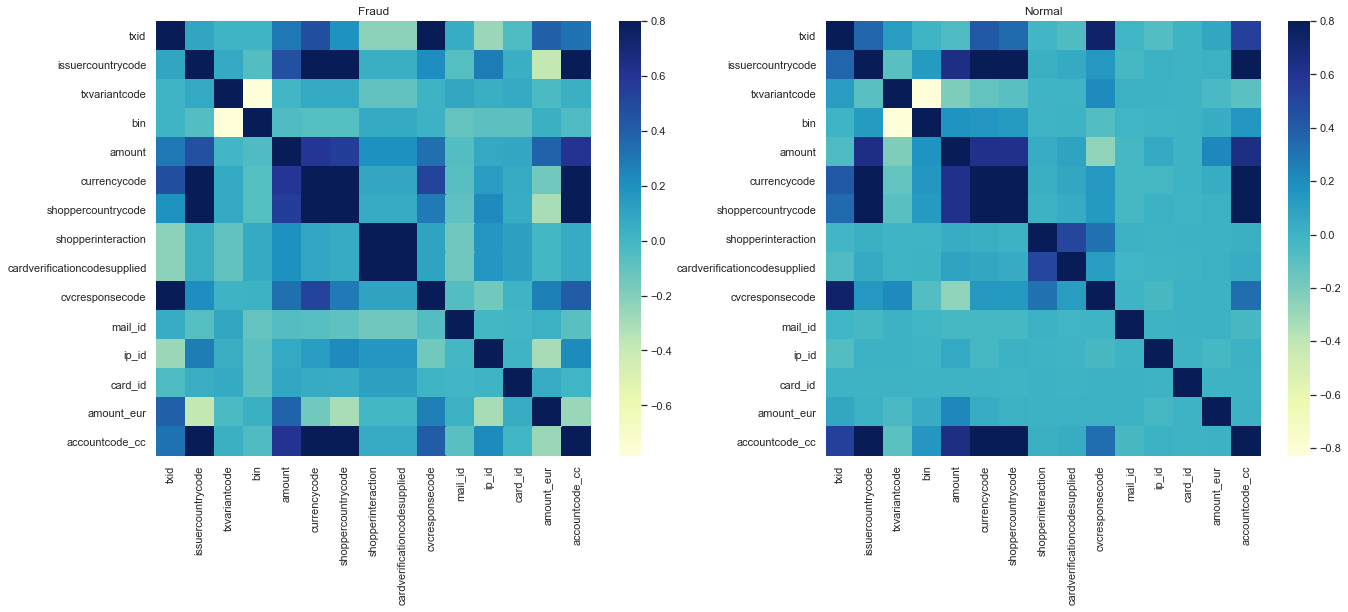

In [20]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df.query('simple_journal==1').drop(columns=["simple_journal"]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df.query('simple_journal==0').drop(columns=["simple_journal"]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

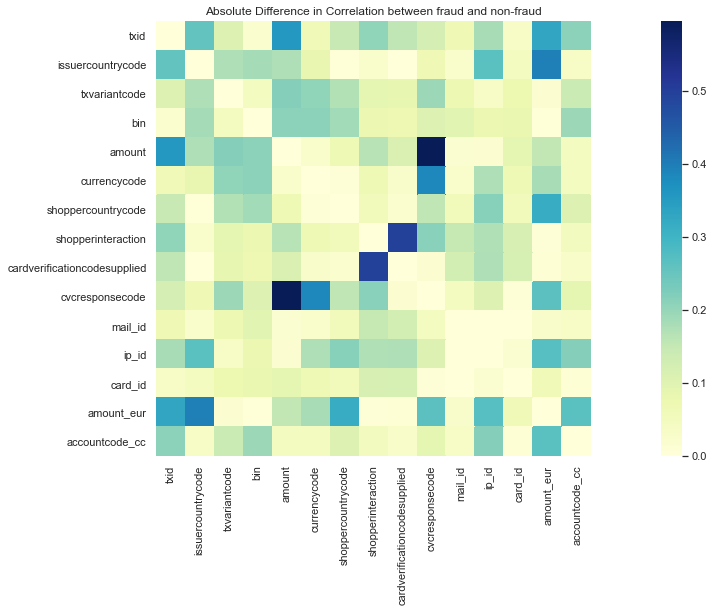

In [21]:
f, (ax1) = plt.subplots(1,figsize =(25, 8))
abs_diff_in_corr = np.abs(df.query('simple_journal==0').drop(columns=["simple_journal"]).corr() - df.query('simple_journal==1').drop(columns=["simple_journal"]).corr())
sns.heatmap(abs_diff_in_corr, square=True, cmap = 'YlGnBu')
ax1.set_title('Absolute Difference in Correlation between fraud and non-fraud')
plt.show()

We see clearly that many feature pairs with absolute difference between correlation for non-fraud and fraud in light blue blocks can discriminate one of the classes better than other. This shows that the interaction effect of some pairs of features have greater power of classifying either one of the classes. Here these are (amount, txid), (amount, cvcresponsecode), (cardverificationsupplied, shopperinterraction), etc.

---
## B. Visualize currencycode

Are transactions made in some currencies pre-disposed to having more fraudulent transactions?

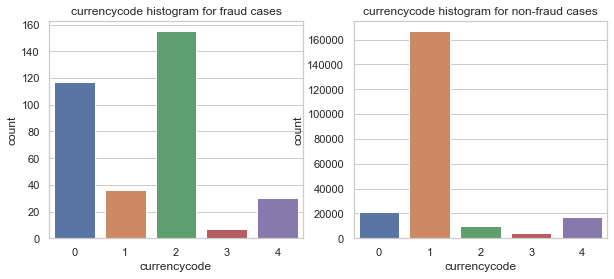

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.countplot(data=df[df.simple_journal == 1], x="currencycode", ax=ax1)
ax1.set_title('currencycode histogram for fraud cases')

sns.countplot(data=df[df.simple_journal == 0], x="currencycode", ax=ax2)
ax2.set_title('currencycode histogram for non-fraud cases')
plt.show()

We can see that transactions with `currencycode` = 1 have higher likelihood of being fraudulent.

---
## C. Visualize Card Type

Are transactions made using some credit card types pre-disposed to having more fraudulent transactions?

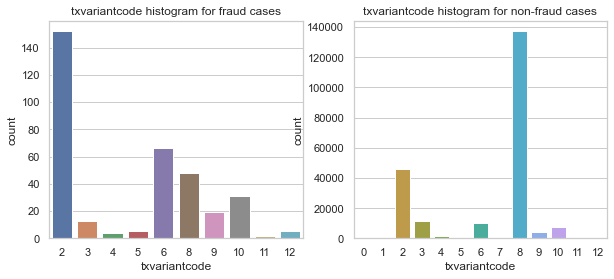

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))

sns.countplot(data=df[df.simple_journal == 1], x="txvariantcode", ax=ax1)
ax1.set_title('txvariantcode histogram for fraud cases')

sns.countplot(data=df[df.simple_journal == 0], x="txvariantcode", ax=ax2)
ax2.set_title('txvariantcode histogram for non-fraud cases')
plt.show()

`txvariantcode` = 2 and 8 have a higher likelihood of being fraudulent

---

# D. Visualize Card Issuer

Do some transaction made using cards from certain card issuers entail more fraud?

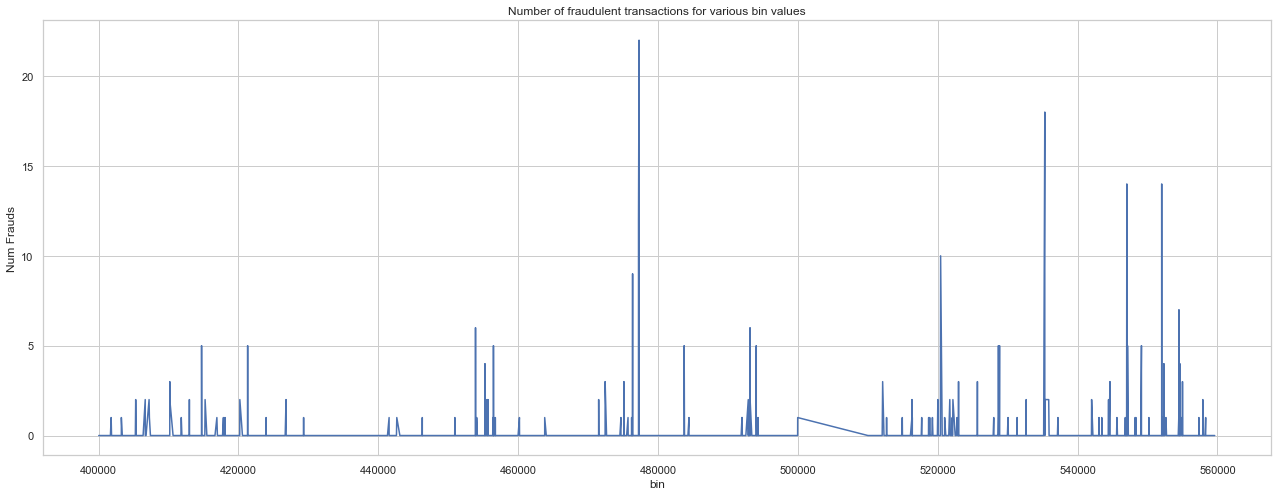

In [24]:
bin_df = df[['bin','simple_journal']].groupby(['bin']).sum()
bin_df = bin_df.sort_index()
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax.set_title("Number of fraudulent transactions for various bin values")
sns.lineplot(x=bin_df.index,y=bin_df['simple_journal'])
ax.set(ylabel = "Num Frauds")
plt.show()

We can see that some card issuers do have a tendency to accrue higher fraudulent transactions from their cards

---

## E. CVCResponseCode

Are transactions that have certain cvcresponse codes pre-disposed to being fraudulent?

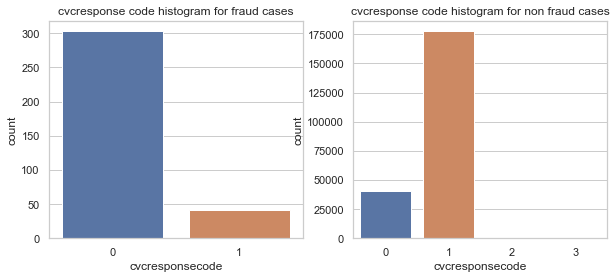

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="cvcresponsecode", data=df[df.simple_journal == 1], ax=ax1)
ax1.set_title('cvcresponse code histogram for fraud cases')

sns.countplot(x="cvcresponsecode", data=df[df.simple_journal == 0], ax=ax2)
ax2.set_title('cvcresponse code histogram for non fraud cases')
plt.show()

We can see that the cvcresponsecode 0 is more prominent in cases of fraud, whereas 1 is more prominent in non-fraud cases

---

## F. Isomap

The isometrically consistent 2D representation shows us that the fraud cases are either outliers to the normal transaction patterns or form small clusters (shown by many overlapping red points in the plot) in the feature space. We can see this in the below visualization where some red dots appear outside the blue manifold and other cluster within

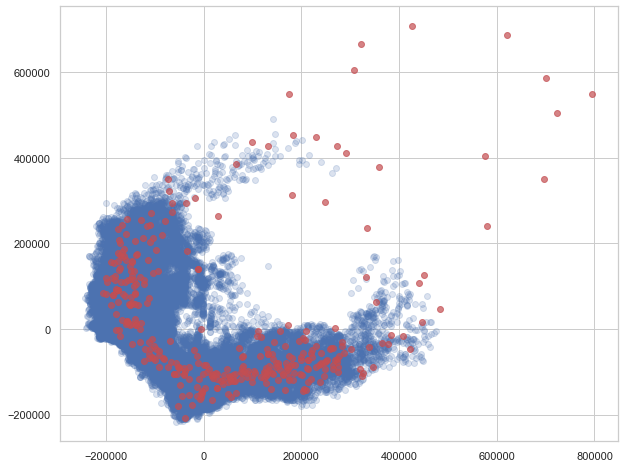

In [26]:
HAVE_MORE_THAN_10Gb_RAM = False

undersampling = 0.001   # 0.1% of non-frawd sampled
if HAVE_MORE_THAN_10Gb_RAM:
    undersampling = 0.01    # 1% of non-frawd sampled

fraud_index = np.where(df['simple_journal'] == 1)[0]
not_fraud_index = np.where(df['simple_journal'] == 0)[0]
not_fraud_index_ = np.random.choice(not_fraud_index, size= int (undersampling*len(not_fraud_index)), replace=False)
columns = ['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','mail_id','accountcode_cc','ip_id','card_id','amount_eur']
X = df[columns]
isomap = Isomap(n_components=2, n_jobs=-1, neighbors_algorithm='kd_tree')
isomap.fit(X.iloc[np.union1d(fraud_index, not_fraud_index_), :])
X_embedded = isomap.transform(X)
X_embedded.shape

fig = plt.figure(figsize=(10,8))

frawd_index = np.where(df['simple_journal'] == 1)[0]
not_frawd_index = np.where(df['simple_journal'] == 0)[0]

plt.scatter(X_embedded[not_frawd_index, 0], X_embedded[not_frawd_index, 1], c='b', alpha=0.2)
plt.scatter(X_embedded[frawd_index, 0], X_embedded[frawd_index, 1], c='r', alpha=0.7)

plt.show()

---
---

# III. Subsampling the Majority Class

The class imbalance between fraud and non-fraud is quite stark. We see the distribution below.

In [27]:
non_fraud_count = df[df["simple_journal"] == 0].shape[0]
fraud_count = df[df["simple_journal"] == 1].shape[0]
print(f"Class Distribution: fraud = {fraud_count}({round(100*fraud_count/df.shape[0], 2)}%), non-fraud = {non_fraud_count}({round(100*non_fraud_count/df.shape[0], 2)}%)")

Class Distribution: fraud = 345(0.16%), non-fraud = 218408(99.84%)


We would like to retain all fraud samples while sub-sampling about 10% of the non-fraud cases.

We do this below:

In [28]:
df_resample = pd.concat((df[df["simple_journal"] == 0].sample(frac=0.1, random_state=1337), df[df["simple_journal"] == 1]))

In [29]:
non_fraud_count = df_resample[df_resample["simple_journal"] == 0].shape[0]
fraud_count = df_resample[df_resample["simple_journal"] == 1].shape[0]
print(f"Resampled Class Distribution: fraud = {fraud_count}({round(100*fraud_count/df_resample.shape[0], 2)}%), non-fraud = {non_fraud_count}({round(100*non_fraud_count/df_resample.shape[0], 2)}%)")

Resampled Class Distribution: fraud = 345(1.56%), non-fraud = 21841(98.44%)


---
---

# IV. Feature Engineering and Standardization

Here, we create features by transforming and/or combining existing features.

## A. countries_equal: Shopped Country = Country in which Card was Issued

The intuition is that if the country in which the money was spent is not the same as the country in which the card was issued, it is likely that the transaction was fraudulent.

In [30]:
df_resample["countries_equal"] = df_resample["shoppercountrycode"] == df_resample["issuercountrycode"]
df_resample.loc[df_resample["countries_equal"] == False, "countries_equal"] = 0
df_resample.loc[df_resample["countries_equal"] == True, "countries_equal"] = 1

## B. Time of Transaction: Day of Week and Hour of Day

In [31]:
df_resample["day_of_week"] = df_resample["creationdate"].dt.dayofweek
df_resample["hour"] = df_resample["creationdate"].dt.hour

Visualize if fraudulent transactions happen at specific times or hours of the day

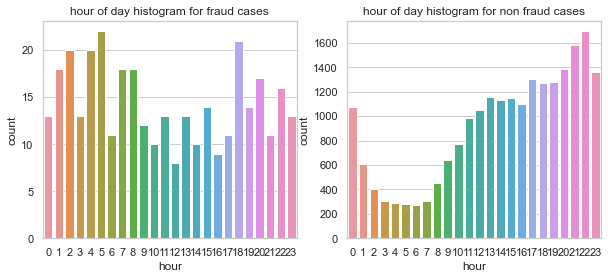

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize =(10, 4))
sns.countplot(x="hour", data=df_resample[df_resample.simple_journal == 1], ax=ax1)
ax1.set_title('hour of day histogram for fraud cases')

sns.countplot(x="hour", data=df_resample[df_resample.simple_journal == 0], ax=ax2)
ax2.set_title('hour of day histogram for non fraud cases')
plt.show()

There is a clear difference in distribution between fraud and non-fraud. Fraudulent transactions tend to be distributed throughout the day, whereas non-fraudulent transactions gradually increase as the hour passes.

## BONUS TASK: Aggregate Features

We engineer the following features by aggregating over time for credit card. We use transaction aggregation strategy as a way to capture consumer spending behavior in the recent past. We put each credit card transaction into the historical context of past shopping behavior. In essence these attributes provide information on card holders' buying behavior in the immediate past.

- `prev_month_avg_amount`: Average amount spent in the previous month
- `prev_week_avg_amount`: Average amount spent in the previous week
- `prev_day_amount`: Average amount spent in the previous day
- `daily_avg_over_month`: Average amount spent per day in the last month of transactions
- `prev_day_same_country`: Number of transactions in the last 1 day in the same country as in this transaction
- `prev_month_same_country`: Number of transactions in the last 1 month in the same country as in this transaction
- `prev_month_avg_amount_same_country`: Average amount of transactions in the last month in the same country as in this transactions
- `prev_month_same_currency`: Number of transactions in the last 1 month with the same currency as in this transaction
- `prev_month_avg_amount_same_currency`: Average amount of transactions in the last month with the same currency as in this transactions
- `prev_total_transactions`: Total previous transactions with this credit card

Script used for creating aggregate features can be found in [Part1/aggregate_features.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/aggregate_features.py)

In [33]:
from aggregate_features import aggregate_features

### NOTE: the cell below will take about 8 minutes

In [34]:
df_resample = aggregate_features(df_resample)

We visualize some of these below to show that they have different replationship with the label. These features are much lower and distributed more tightly around 0 for fraudulent transactions as compared to non-fraud transactions.

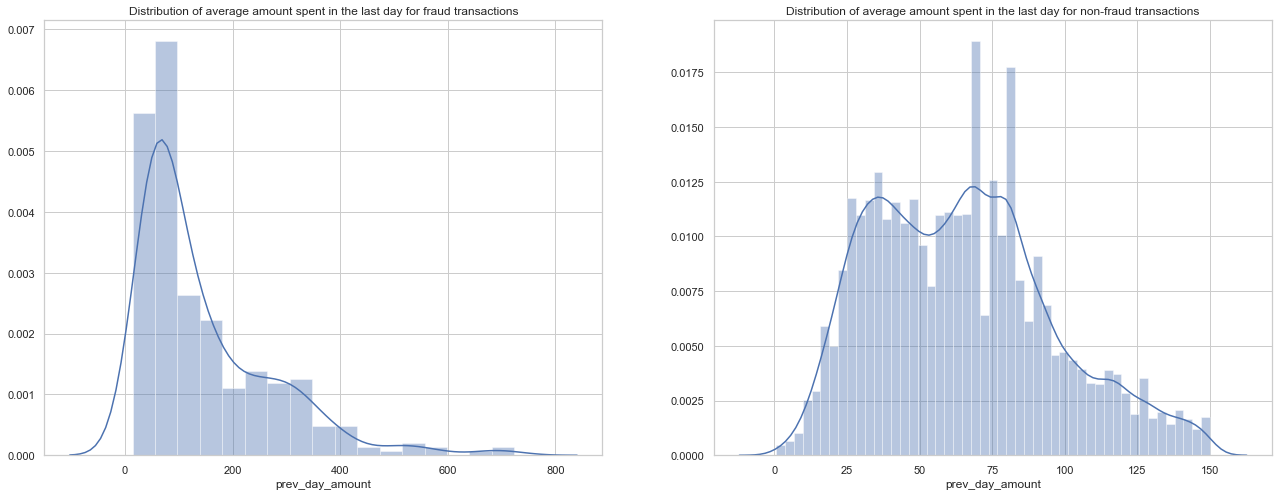

In [35]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==1]["prev_day_amount"], ax=ax1)
ax1.set_title("Distribution of average amount spent in the last day for fraud transactions")

sns.distplot(df_resample[df_resample.simple_journal==0]["prev_day_amount"], ax=ax2)
ax2.set_title("Distribution of average amount spent in the last day for non-fraud transactions")
plt.show()

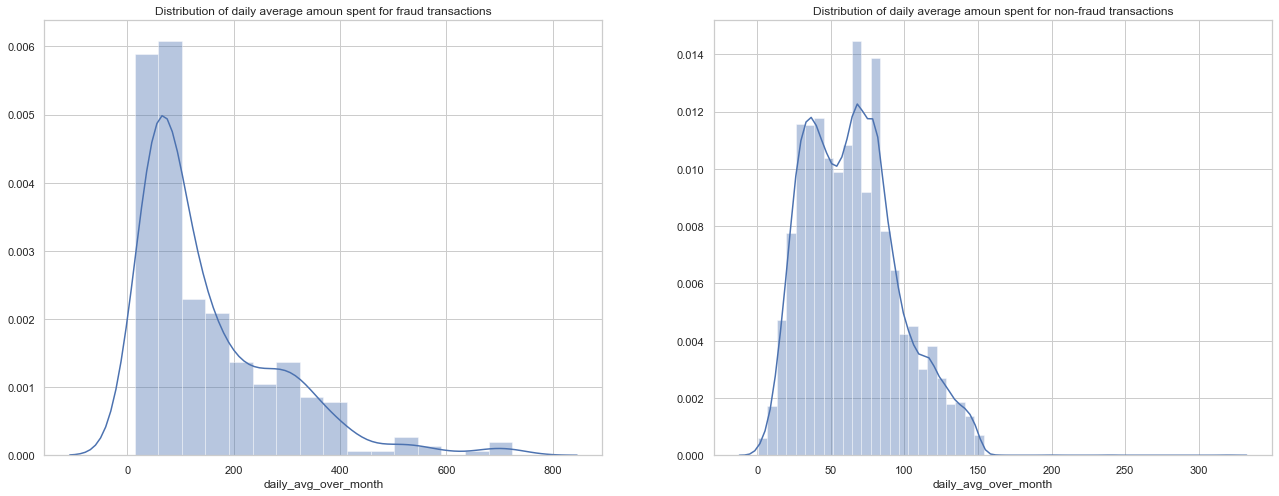

In [36]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_resample[df_resample.simple_journal==1]["daily_avg_over_month"], ax=ax1)
ax1.set_title("Distribution of daily average amoun spent for fraud transactions")

sns.distplot(df_resample[df_resample.simple_journal==0]["daily_avg_over_month"], ax=ax2)
ax2.set_title("Distribution of daily average amoun spent for non-fraud transactions")
plt.show()

In [37]:
df_resample.columns

Index(['accountcode_cc', 'amount', 'amount_eur', 'bin', 'bookingdate',
       'card_id', 'cardverificationcodesupplied', 'countries_equal',
       'creationdate', 'currencycode', 'cvcresponsecode',
       'daily_avg_over_month', 'date', 'day_of_week', 'hour', 'ip_id',
       'issuercountrycode', 'mail_id', 'prev_day_amount',
       'prev_day_same_country', 'prev_month_avg_amount',
       'prev_month_avg_amount_same_country',
       'prev_month_avg_amount_same_currency', 'prev_month_same_country',
       'prev_month_same_currency', 'prev_total_transactions',
       'prev_week_avg_amount', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'txid', 'txvariantcode'],
      dtype='object')

In [38]:
features = ['accountcode_cc', 'amount_eur', 'bin', 'cardverificationcodesupplied', 'countries_equal', 'currencycode', 'cvcresponsecode', 'daily_avg_over_month', 'day_of_week', 'hour', 'ip_id', 'issuercountrycode', 'prev_day_amount', 'prev_day_same_country', 'prev_month_avg_amount', 'prev_month_avg_amount_same_country', 'prev_month_avg_amount_same_currency', 'prev_month_same_country', 'prev_month_same_currency', 'prev_total_transactions', 'prev_week_avg_amount', 'shoppercountrycode', 'shopperinteraction', 'txvariantcode']

In [39]:
X = df_resample[features].to_numpy().astype("float32")
y = df_resample["simple_journal"].to_numpy().astype("int32")

In [40]:
np.savez("./data/train_data.npz", X=X, y=y)

## Note: the above cell saves the data with all pre-processing to disk
## If you have run and saved this to disk once, run from the next cell to load data (and save time!)

In [41]:
train_data = np.load("./data/train_data.npz")
X = train_data["X"]
y = train_data["y"]

---
---

# V. Classification Task

We decided to compare 2 models:
1. Decision Tree Classifier (White Box)
2. Support Vector Classifier (Black Box)

In our github repository:
- [Part-1/models.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/models.py) contains our models
- [Part-1/metrics.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/metrics.py) computes our metrics
- [Part-1/visualization.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/visualization.py) plots the AUC curve and feature importances

## Metrics

We evaluate the models based on:

1. The number of True Positives (higher is better)
2. The number of False Positives (lower is better)
3. The ROC curve

which shows how the model allows a tradeoff between TPs and FPs. We would like the model to have a high number of true positives while keeping the false positives low.

We also look at the Precision and Recall to justify which model should be used in which situation

In [47]:
from models import models
from visualization import plot_feature_importances, plot_roc_auc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

## Standardize Data

We normalize the features by making the data zero mean and unit standard deviation. This is because most ML algorithms assume that the data is distributed normally and work well when data is distributed normally around 0.

In [43]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

## K Fold Cross Validation

We would like to evaluate our models on a train and validation set. We use the k fold cross validation method since it allows for multiple evaluations to get a variance estimate on our metrics

In [44]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
kfold.get_n_splits(X, y)

splits = list(kfold.split(X, y))

10

## Decision Tree Classifier (White Box Classifier)

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

The paths from root to leaf represent classification rules. If a given sample and corresponding result is observable, the explanation for the result is easily explained by boolean logic. 
Making sure that we can explain why a transaction is labeled as being fraudulent.

Using the final decision tree with weighted notes, we can get feature importance.

**Feature importance** is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

Fraudulent Cases Found: 183, False Positives: 222
Recall: 0.5305882352941176, Precision: 0.4532809851199002


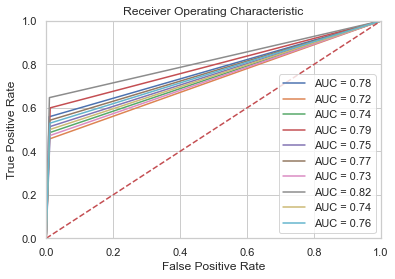

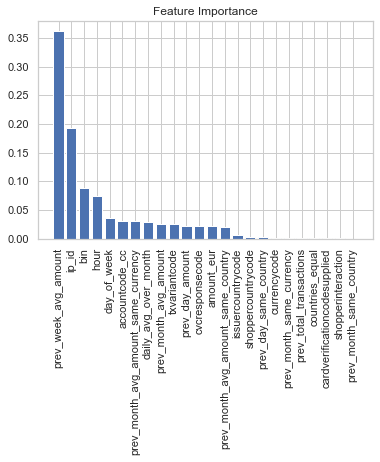

In [48]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    result = models.DecisionTree(X_train, X_test, y_train, y_test)
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)
    importances += model.feature_importances_
importances /= 10.0
print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")
print(f"Recall: {sum(result_set['recall'])/10.0}, Precision: {sum(result_set['precision'])/10.0}")
plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])
plot_feature_importances(importances, features)

## Support Vector Classifier (Black-box Model)

A support-vector machine constructs a hyperplane or set of hyperplanes in a infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class - the margin, since in general the larger the margin, the lower the generalization error of the classifier.

The support vector machine method an be use to do non-linear classification as well by using the kernel trick. It often happens that the data are not linearly separable. Using the kernel trick, the original finite-dimensional space be mapped into a much higher-dimensional space, presumably making the separation easier in that space.

**This particular step of transferring a problem to a higher dim space makes SVC a black box model.**

Fraudulent Cases Found: 101, False Positives: 2
Recall: 0.29294117647058826, Precision: 0.9805555555555557


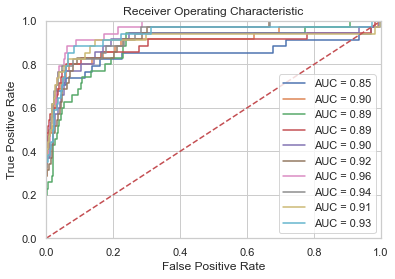

In [49]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    result = models.SVC(X_train, X_test, y_train, y_test, {"C": 1, "kernel": "poly"})
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)

print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")
print(f"Recall: {sum(result_set['recall'])/10.0}, Precision: {sum(result_set['precision'])/10.0}")
plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

### Result:

The SVC is able to get a higher task performance than the decision tree classifier in terms of AUC score (~ 90). This means that the model can very well distinguish between the two classes. The variance in the AUC is also quite small.

Additionally, the SVC correctly identifies 101 fraudulent cases while only reporting 2 False Positives. This is excellent news! Given that there are a many many more non-fraud cases, if the false positives were high, we would have to cancel credit cards of many people which would lead to inconvenience.

However, looking at the recall of the SVC, we see that it averages only about 0.29 across the folds which means that it can capture only about 30% of the total fraudulent transactions. Whereas, the decision tree model has a recall of over 50%. But it does this at the cost of a higher false positive rate (222 false positives).

A positive note about the decision tree is that it can explain its predictions through the feature importance and the boolean logic of how it classified a result. We can see the plot of the feature importances above. This can be helpful in many legal cases where a company might be required to tell a customer why it cancelled its transaction/credit card.

**In conclusion:** No one model is suitable for all cases

- if goal is explainability: choose decision tree (white box model)

- if false positives are expensive, eg: loss of customer due to incorrectly cancelling credit card, choose high precision model (in this case SVC)

- if false negatives are expensive, eg: letting go of some fraud cases, choose high recall model (in this case Decision Tree)

---

---

# VI. Imbalance Task
**by Student ID 4998707**

We use SMOTE to oversample the minority class to reduce the class imbalance. We have already undersampled the majority class earlier.

SMOTE is a technique to synthetically generate samples of the minority class so that they are similar to the existing samples in a vector space of their attributes. This is different from repeated oversampling which samples the minority class with replacement. This changes the overall distribution of the data and SMOTE is a way to retain a bit of the original distribution.

Below, we show our experiments. We train 3 models:

1. Decision Tree Classifier
2. Naive Bayes Classifier
3. Support Vector Classifier

on the SMOTEd and unSMOTEd data and compare the True/False Positives and corresponding AUCs.

For the unSMOTEd data, the class imbalance is 99.44% to 1.56%.. For the SMOTEd data, we restore the class balance to 50-50.

We were not able to train the SVC classifier on the SMOTEd data because the upsampling increase the dataset size too much that training takes forever.

Script used for SMOTE can be found in [Part-1/smote.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/smote.py)

In [50]:
from smote import SMOTE
from collections import defaultdict

In [51]:
results = {}

print(f"unSMOTEd Fraud Class percentage: {round(100*y.sum()/y.shape[0], 2)}%")

unSMOTEd Fraud Class percentage: 1.56%


## A. Decision Tree Classifier

### unSMOTEd

Fraudulent Cases Found: 183, False Positives: 222


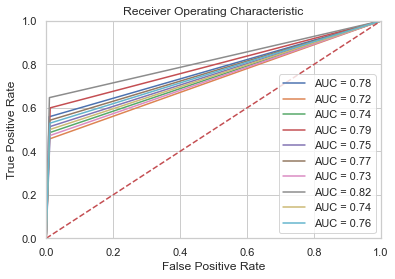

In [52]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    result = models.DecisionTree(X_train, X_test, y_train, y_test)
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)
    importances += model.feature_importances_
importances /= 10.0
print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

### SMOTEd data

Fraudulent Cases Found: 167, False Positives: 10835


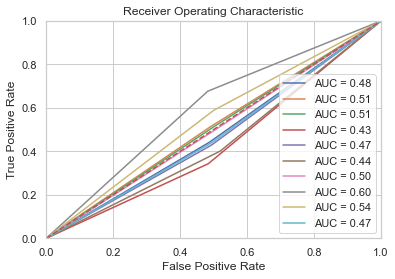

In [53]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sm = SMOTE(p=50, k=5)
    sm.fit(X_train, y_train)
    X_train, y_train = sm.transform()
    
    result = models.DecisionTree(X_train, X_test, y_train, y_test)
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)
    importances += model.feature_importances_
importances /= 10.0
print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

---

---

## B. NaiveBayes Classifier

### unSMOTEd data

Fraudulent Cases Found: 139, False Positives: 486


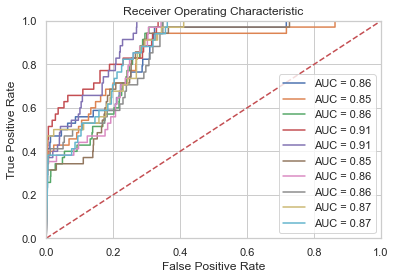

In [54]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    result = models.NaiveBayes(X_train, X_test, y_train, y_test)
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)

print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

### SMOTEd data

Fraudulent Cases Found: 182, False Positives: 9198


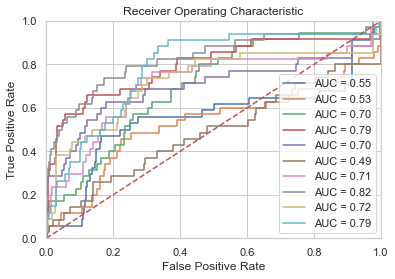

In [55]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sm = SMOTE(p=50, k=5)
    sm.fit(X_train, y_train)
    X_train, y_train = sm.transform()
    
    result = models.NaiveBayes(X_train, X_test, y_train, y_test)
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)

print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

---

---

## C. Support Vector Classifier

### unSMOTEd data

Fraudulent Cases Found: 101, False Positives: 2


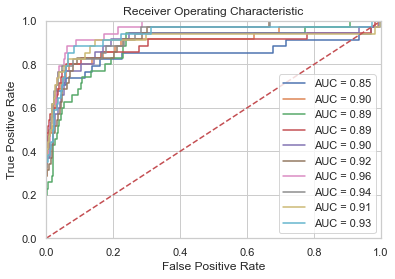

In [56]:
result_set = defaultdict(list)
importances = np.zeros((X.shape[1]))
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    result = models.SVC(X_train, X_test, y_train, y_test, {"C": 1, "kernel": "poly"})
    model = result['model']
    del result['model']
    for k, v in result.items():
        result_set[k].append(v)

print(f"Fraudulent Cases Found: {sum(result_set['tp'])}, False Positives: {sum(result_set['fp'])}")

plot_roc_auc_curve(result_set["false_pos_rate"], result_set["true_pos_rate"], result_set["auc"])

### SVC on SMOTEd data (did not run)

- does not complete in a reasonable amount of time
- requires a large amount of memory to store the covaraiance matrix
- hence infeasible to run on SMOTEd data

### Results

According to the results above, the support vector classifier performs the best among the three. It has an average AUC of around 90. It finds 101 positives accurately with only 2 false positives.

The NaiveBayes classifier is quite good as well since it gives an AUC of 86.

The Decision Tree Classifier does not work well after SMOTEing.

SMOTE is generally a good idea since it:
- allows us to increase the number of minority samples
- does not repeat the same samples while over sampling
- smartly oversample by interpolating between nearest neighbours to maintain the data distribution

SMOTE does not work in all cases, namely for simple Decision Trees since they are a bit different from other nonparametric statistical methods in that they cannot generalize to variations not seen in the training set. This is because a decision tree creates a partition of the input space and needs at least one example in each of the regions associated with a leaf to make a sensible prediction in that region. Since we do not do SMOTE for the validation/test set it performs poorly.

To be robust to these variations, one should use forests or even deeper architectures instead of trees, which provide a form of distributed representation and can generalize to variations not encountered in the training data

---
---

# VII. Rank Swapping 
**by Student ID 5011639**

We decided to apply rank swapping on all columns which may financial, personal or temporal information. This is because numeric as well as categorical feature may be used to link actual individuals to the records.

Lets see how the performance for NAive Bayes, Decision Tree and SVM are affected by rank-swapping by controlling the parameter `p` which controls the number of rows a partcular column value can be swapped within.

For the implementation of Rank Swapping please see [Part-1/rank_swapping.py](https://github.com/sharwinbobde/cyber-data-analytics/blob/master/Part-1/rank_swapping.py)

In [57]:
from rank_swapping import rank_swapping
from sklearn.model_selection import train_test_split
from preprocessing import preprocess

In [58]:
results = []

for p in [0, 2, 5, 10]:
    data = "./data/data_for_student_case.csv"
    df1 = pd.read_csv(data)

    #rankswap
    swap_cols = ['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id']
    df1 = rank_swapping(df1, p, swap_cols)

    #preprocess
    df1 = preprocess(df1, undersample=True)

    x_columns = ['txid', 'issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode', 'mail_id', 'ip_id', 'card_id', 'amount_eur', 'accountcode_cc', 'countries_equal', 'day_of_week', 'hour']
    X = df1[x_columns].to_numpy(dtype=np.float)
    Y = df1['simple_journal'].to_numpy(dtype=np.int)

    print(np.argwhere(np.isnan(X)))
    nans = ~np.isnan(X).any(axis=1)
    X = X[nans] # remove NaN
    Y = Y[nans] # remove NaN
    print( np.shape(X))

    #build and evaluate model
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    result = models.try_all(X_train, X_test, Y_train, Y_test)
    result['p'] = p
    results.append(result)

RankSwapping with p = 0
Not Swapping :)


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/p

[]
(24014, 19)


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RankSwapping with p = 2
swapped 5%
swapped 11%
swapped 17%
swapped 23%
swapped 29%
swapped 35%
swapped 41%
swapped 47%
swapped 52%
swapped 58%
swapped 64%
swapped 70%
swapped 76%
swapped 82%
swapped 88%
swapped 94%
swapped 100%


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/p

[]
(24014, 19)


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RankSwapping with p = 5
swapped 5%
swapped 11%
swapped 17%
swapped 23%
swapped 29%
swapped 35%
swapped 41%
swapped 47%
swapped 52%
swapped 58%
swapped 64%
swapped 70%
swapped 76%
swapped 82%
swapped 88%
swapped 94%
swapped 100%


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/p

[]
(24014, 19)


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RankSwapping with p = 10
swapped 5%
swapped 11%
swapped 17%
swapped 23%
swapped 29%
swapped 35%
swapped 41%
swapped 47%
swapped 52%
swapped 58%
swapped 64%
swapped 70%
swapped 76%
swapped 82%
swapped 88%
swapped 94%
swapped 100%


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/p

[]
(24014, 19)


/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model AUC Plots for observing Rank Swapping effects.

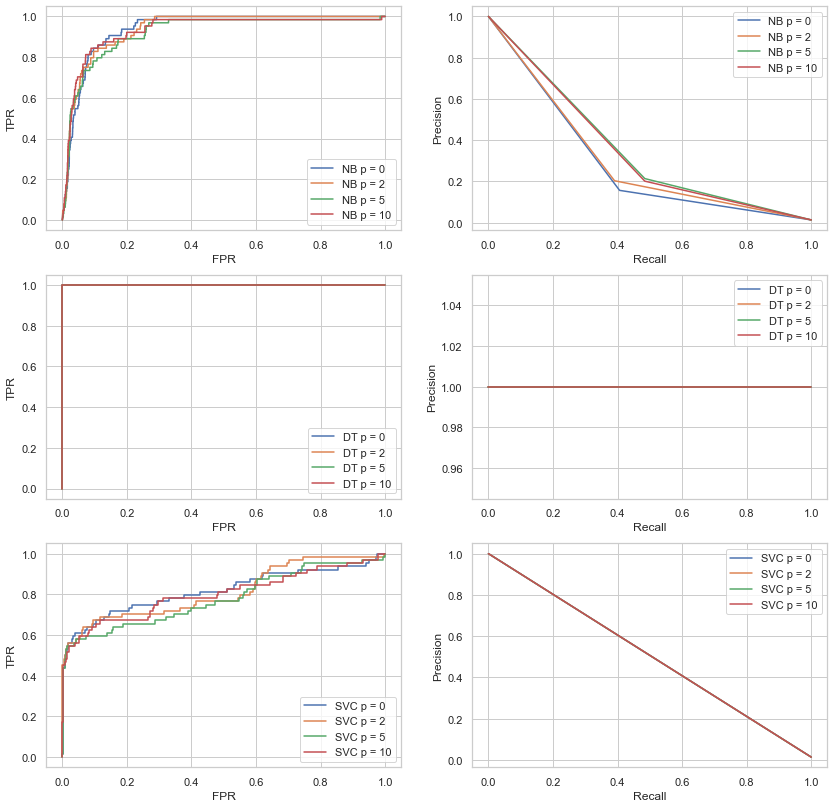

In [59]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(14,14)

for i in range(3):
    axs[i,0].set_xlabel("FPR")
    axs[i,0].set_ylabel("TPR")

    axs[i,1].set_xlabel("Recall")
    axs[i,1].set_ylabel("Precision")

#print("p  accuracy  precision  recall  F1 ")
#print('------------------------------------------')
for result in results:
    p = result['p']
    result_ = result['NaiveBayes']
    #print(str(p) + "\t"+ str(result_['accuracy']) + "\t" +str(result_['precision']) + "\t" +str(result_['recall']) + "\t" +str(result_['f1']))

    axs[0,0].plot(result_['false_pos_rate'], result_['true_pos_rate'], label="NB p = "+str(p))
    axs[0,1].plot(result_['recall_curve'], result_['precision_curve'], label="NB p = "+str(p))

    result_ = result['DecisionTree']
    #print(str(p) + "\t"+ str(result_['accuracy']) + "\t" +str(result_['precision']) + "\t" +str(result_['recall']) + "\t" +str(result_['f1']))

    axs[1,0].plot(result_['false_pos_rate'], result_['true_pos_rate'], label="DT p = "+str(p))
    axs[1,1].plot(result_['recall_curve'], result_['precision_curve'], label="DT p = "+str(p))

    result_ = result['SVC']
    #print(str(p) + "\t"+ str(result_['accuracy']) + "\t" +str(result_['precision']) + "\t" +str(result_['recall']) + "\t" +str(result_['f1']))

    axs[2,0].plot(result_['false_pos_rate'], result_['true_pos_rate'], label="SVC p = "+str(p))
    axs[2,1].plot(result_['recall_curve'], result_['precision_curve'], label="SVC p = "+str(p))

for i in range(3):
    axs[i,0].legend()
    axs[i,1].legend()
plt.show()

## Results
The plots show that Rank Swapping has the following effect on the models:
*   **Naive Bayes**: ROC characteristics mostly unchanged but Precision-Recall curve sees major changes woth p=10 (more swapping) leading to greater generalization
*   **Decision Tree**: No change. Must be because it generalizes well as it is a rule based classifier
*   **Support Vector Machine**: minor changes in the ROC but no change in the Precision-Recall curve.

To answer the Rank Swapping question, with the intention of preserving users' privacy, rank-swapping does not come at a great cost of performance of the models. Thus, it is advisable to protect people's privacy using rank-swapping.